# Transfer learning: fine-tuning

In [98]:
!python -m pip install tensorflow-gpu==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
!nvidia-smi

Fri Mar 17 00:29:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |   4899MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [100]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-17 00:29:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-17 00:29:19 (58.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [101]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## 1. Model 0 

Build a transfer learning model using keras functinal API.

### Get the data 

In [102]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-03-17 00:29:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  22.1MB/s    in 8.3s    

2023-03-17 00:29:28 (19.5 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [103]:
unzip_data('/content/10_food_classes_10_percent.zip')

In [104]:
walk_through_dir('/content/10_food_classes_10_percent')

There are 2 directories and 0 images in '/content/10_food_classes_10_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '/content/10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '/content/10_food_classes_10_perc

In [105]:
train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

In [106]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory 

training_data_10 = image_dataset_from_directory(train_dir,
                                             image_size=(224,224),
                                             label_mode='categorical',
                                             batch_size=32)
testing_data_10 = image_dataset_from_directory(test_dir,
                                            image_size=(224,224),
                                            batch_size=32,
                                            label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [107]:
training_data_10

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [108]:
training_data_10.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Build the model

In [109]:
# We will use EfficientNetB0 https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0
# 1.Creat base model we goint to use in the model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2.Freeze the base model patterns
base_model.trainable= False

# 3.Creat input layer 
input = tf.keras.layers.Input(shape=(224,224,3), name='Input_layer')
print(f"The shape of input layer: {input.shape}")
# 4.Normalize the input if we use ResNet base model
#x = tf.keras.experimental.preprocessing.Rescaling(1/255.)(input)

# 5.Pass the input to the base model 
x = base_model(input)
print(f'The shape of passing the input to the base model: {x.shape}')

# 6.Pooling
x = tf.keras.layers.GlobalAveragePooling2D(name='pooling_layer')(x)
print(f'The shape of passing the output of the base model to the pooling layer: {x.shape}')

# 7.Creat the output layer
output = tf.keras.layers.Dense(10, activation='softmax',name='output_layer')(x)

# 8.Combine the input with the output into model
model_0 = tf.keras.Model(input, output)

The shape of input layer: (None, 224, 224, 3)
The shape of passing the input to the base model: (None, 7, 7, 1280)
The shape of passing the output of the base model to the pooling layer: (None, 1280)


In [110]:
model_0.compile(loss = 'categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
history_0 = model_0.fit(training_data_10,
                        epochs=5,
                        steps_per_epoch=len(training_data_10),
                        validation_data=testing_data_10,
                        validation_steps=len(testing_data_10))
                        #callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='Checkpoint')])

Epoch 1/5
24/24 [==============================] - 19s 394ms/step - loss: 1.9129 - accuracy: 0.3960 - val_loss: 1.3542 - val_accuracy: 0.6924
Epoch 2/5
24/24 [==============================] - 8s 315ms/step - loss: 1.1553 - accuracy: 0.7347 - val_loss: 0.9309 - val_accuracy: 0.7904
Epoch 3/5
24/24 [==============================] - 9s 380ms/step - loss: 0.8584 - accuracy: 0.7960 - val_loss: 0.7548 - val_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 7s 299ms/step - loss: 0.6934 - accuracy: 0.8347 - val_loss: 0.6645 - val_accuracy: 0.8400
Epoch 5/5
24/24 [==============================] - 9s 370ms/step - loss: 0.6074 - accuracy: 0.8667 - val_loss: 0.6095 - val_accuracy: 0.8420


In [111]:
model_0.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Evaluate it 

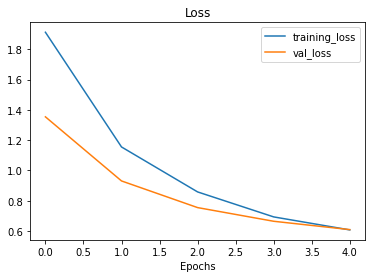

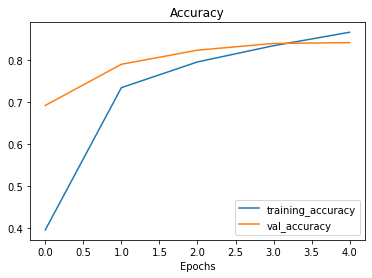

In [112]:
plot_loss_curves(history_0)

In [113]:
# Global Average pooling rule in the model and who its work
input_shape = (1,4,4,3)
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
input_tensor 

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.23479682, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [114]:
#pass the random tensor to the GlobalAveragePooling2D layer 
pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # we see that the avpool get rid of the middel tow shape 
pooled_tensor                                                          # and make it a vector of the first and last dimintions

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [115]:
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [116]:
max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
max_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Model 1


* `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation

In [117]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

### Download & Preprossing the data

In [118]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-03-17 00:30:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  22.8MB/s    in 6.7s    

2023-03-17 00:30:38 (19.1 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [119]:
unzip_data('/content/10_food_classes_1_percent.zip')

In [120]:
walk_through_dir('/content/10_food_classes_1_percent')

There are 2 directories and 0 images in '/content/10_food_classes_1_percent'.
There are 10 directories and 0 images in '/content/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '/content/10_food_classes_1_percent/train/hamburger'

In [121]:
train_dir_1per = '/content/10_food_classes_1_percent/train'
test_dir_1 = '/content/10_food_classes_1_percent/test'

In [122]:
training_data_1 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1per,
                                                                    label_mode='categorical',
                                                                    batch_size=32,
                                                                    image_size=(224,224))
testing_data_1 = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1,
                                                                   label_mode='categorical',
                                                                   batch_size=32,
                                                                   image_size=(224,224))

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [123]:
# Add data augmintation to the model 
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
  #preprocessing.Rescaling(1/255.)   # EfficientNet has rescaling built in 
],name='data_augmentation')

### Visualize the augmented data 

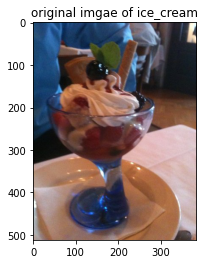

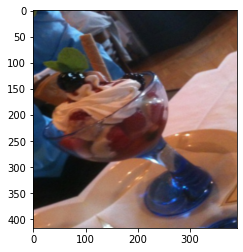

In [124]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(training_data_1.class_names)
image_path = '/content/10_food_classes_1_percent/train' +'/'+ target_class
random_image = random.choice(os.listdir(image_path))
img = image_path +'/'+ random_image

#plot the orginal image
img = mpimg.imread(img)
plt.imshow(img)
plt.title(f'original imgae of {target_class}')

# plot the augmented image 
plt.figure()
augmented_img = data_augmentation(img, training=True)
plt.imshow(augmented_img/255.)

In [125]:
img_shape = (224,224)

In [126]:
img_shape + (3,)

(224, 224, 3)

### build the model

In [127]:
base_model_1 = tf.keras.applications.EfficientNetB1(include_top=False)
base_model_1.trainable = False

# Create input layer
inputs = layers.Input(shape=(224,224,3), name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model_1(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

history_1 = model_1.fit(training_data_1,
                        epochs=5,
                        steps_per_epoch=len(training_data_1),
                        validation_data=testing_data_10,
                        validation_steps=len(testing_data_10))

Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.3231 - accuracy: 0.1143

3/3 [==============================] - 19s 5s/step - loss: 2.3231 - accuracy: 0.1143 - val_loss: 2.2239 - val_accuracy: 0.1548
Epoch 2/5
3/3 [==============================] - 9s 4s/step - loss: 2.0591 - accuracy: 0.3286 - val_loss: 2.1032 - val_accuracy: 0.2456
Epoch 3/5
3/3 [==============================] - 9s 4s/step - loss: 1.9948 - accuracy: 0.3286 - val_loss: 1.9971 - val_accuracy: 0.3276
Epoch 4/5
3/3 [==============================] - 8s 4s/step - loss: 1.7678 - accuracy: 0.5143 - val_loss: 1.8973 - val_accuracy: 0.4048
Epoch 5/5
3/3 [==============================] - 9s 4s/step - loss: 1.5969 - accuracy: 0.6714 - val_loss: 1.8102 - val_accuracy: 0.4680


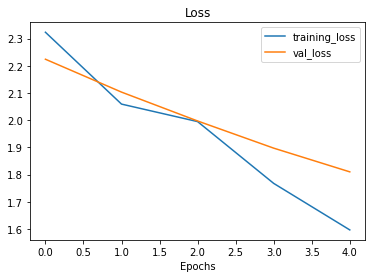

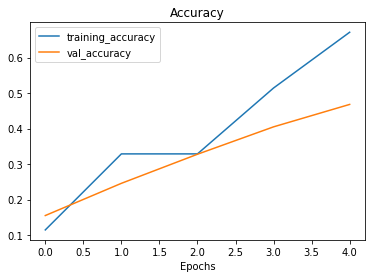

In [128]:
plot_loss_curves(history_1)

In [129]:
model_1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 6,588,049
Trainable params: 12,810
Non-train

## Model 2

In this model we will use the data in model 0, The deffernent that in this model we will use data augmentation.

### main model

In [130]:
# The base model
base_model_2 = keras.applications.EfficientNetB0(include_top=False)
base_model_2.trainable = False  #freezes

# The input layer
input = layers.Input(shape=(224,224,3), name='Input_layer')
# Augmentation layer
x = data_augmentation(input)
# Get the input to the base model
x = base_model_2(x)
# Pooling layer 
x = GlobalAveragePooling2D(name='Pooling_layer')(x)
# The output layer 
output = Dense(10, activation='softmax', name = 'output_layer')(x)

model_2 = Model(input, output)

# Compile it
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics=['accuracy'])

### fit the model with checkpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.



In [131]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='10_per_ModelCheckpoint_weights/checkpoint.ckpt',
                                                         save_weights_only=True,
                                                         save_best_only=False, #default
                                                         save_freq='epoch',#default
                                                         verbose=1)

In [132]:
history_2 = model_2.fit(training_data_10,
                        epochs=5,
                        steps_per_epoch=len(training_data_10),
                        validation_data=testing_data_10,
                        validation_steps=len(testing_data_10),
                        callbacks=checkpoint_callback)

Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 2.0566 - accuracy: 0.3147


Epoch 1: saving model to 10_per_ModelCheckpoint_weights/checkpoint.ckpt
24/24 [==============================] - 17s 510ms/step - loss: 2.0566 - accuracy: 0.3147 - val_loss: 1.5527 - val_accuracy: 0.5864
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4208 - accuracy: 0.6440
Epoch 2: saving model to 10_per_ModelCheckpoint_weights/checkpoint.ckpt
24/24 [==============================] - 11s 467ms/step - loss: 1.4208 - accuracy: 0.6440 - val_loss: 1.1165 - val_accuracy: 0.7328
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1134 - accuracy: 0.7387
Epoch 3: saving model to 10_per_ModelCheckpoint_weights/checkpoint.ckpt
24/24 [==============================] - 12s 482ms/step - loss: 1.1134 - accuracy: 0.7387 - val_loss: 0.9031 - val_accuracy: 0.7748
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.9392 - accuracy: 0.7667
Epoch 4: saving model to 10_per_ModelCheckpoint_weights/checkpoint.ckpt
24/24 [=============================

In [133]:
model_2_evaluate = model_2.evaluate(testing_data_10)

79/79 [==============================] - 6s 67ms/step - loss: 0.7296 - accuracy: 0.8040


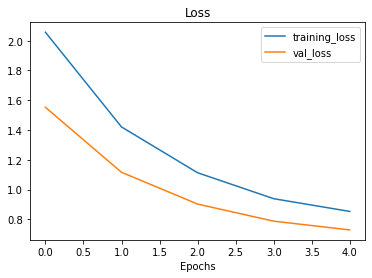

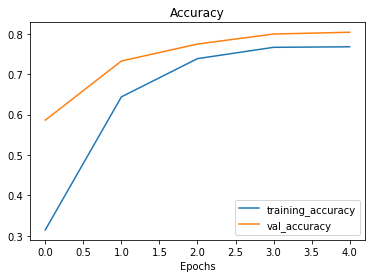

In [134]:
plot_loss_curves(history_2)

In [135]:
# Loading in checkpointed weights returns a model to a specific checkpoint.
model_2.load_weights('10_per_ModelCheckpoint_weights/checkpoint.ckpt')

In [136]:
loaded_weights_model_2_results = model_2.evaluate(testing_data_10)

79/79 [==============================] - 6s 67ms/step - loss: 0.7296 - accuracy: 0.8040


In [137]:
model_2_evaluate == loaded_weights_model_2_results

False

In [138]:
print(model_2_evaluate)
print(loaded_weights_model_2_results)

[0.7296015620231628, 0.8040000200271606]
[0.7296016812324524, 0.8040000200271606]


In [139]:
import numpy as np
np.isclose(np.array(model_2_evaluate),np.array(loaded_weights_model_2_results))

array([ True,  True])

##Model 3: Fine-tuing 

In [140]:
model_2.layers

In [141]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f62ab4c52b0> True
<keras.engine.sequential.Sequential object at 0x7f61f8ec6580> True
<keras.engine.functional.Functional object at 0x7f62202e8910> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f62ab4c5ee0> True
<keras.layers.core.dense.Dense object at 0x7f62900bcee0> True


In [142]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_13 False
1 rescaling_12 False
2 normalization_12 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [143]:
# Trainable variables in model_2 base model
print(len(model_2.layers[2].trainable_variables))

0


In [144]:
# seting last 10 layers of base model to trainaable true
base_model_2.trainable = True

for layer in base_model_2.layers[:-12]:
  layer.trainable=False

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(0.0001),
                metrics =['accuracy'])

In [145]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f62ab4c51c0> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f62ab4c5ca0> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7f62ab4b8400> False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7f62a0277790> False
4 <keras.layers.convolutional.Conv2D object at 0x7f62ab4d8760> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f62ab4bf190> False
6 <keras.layers.core.activation.Activation object at 0x7f62ab41e970> False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f62ab4c1f70> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f62ab432970> False
9 <keras.layers.core.activation.Activation object at 0x7f62a84d6e80> False
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f62a84d61c0> False
11 <keras.layers.core.reshape.Reshape object at 0x7f62a84a2700> False
12 <keras.layers.convo

In [146]:
len(model_2.layers[2].trainable_variables)

12

In [147]:
# Fine the model for more 5 epochs 
history_3 = model_2.fit(training_data_10,
                        epochs = 10,
                        steps_per_epoch=len(training_data_10),
                        validation_data=testing_data_10,
                        validation_steps=int(0.25*len(testing_data_10)),
                        initial_epoch=history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='fine_tune')])

Saving TensorBoard log files to: transfer_learning/fine_tune/20230317-003348
Epoch 5/10


24/24 [==============================] - ETA: 0s - loss: 1.1449 - accuracy: 0.7000

24/24 [==============================] - 15s 317ms/step - loss: 1.1449 - accuracy: 0.7000 - val_loss: 0.6460 - val_accuracy: 0.8322
Epoch 6/10
24/24 [==============================] - 7s 279ms/step - loss: 0.9612 - accuracy: 0.7533 - val_loss: 0.5969 - val_accuracy: 0.8438
Epoch 7/10
24/24 [==============================] - 8s 310ms/step - loss: 0.8120 - accuracy: 0.8120 - val_loss: 0.6143 - val_accuracy: 0.8273
Epoch 8/10
24/24 [==============================] - 8s 299ms/step - loss: 0.7456 - accuracy: 0.8160 - val_loss: 0.6168 - val_accuracy: 0.8158
Epoch 9/10
24/24 [==============================] - 7s 293ms/step - loss: 0.6743 - accuracy: 0.8347 - val_loss: 0.5568 - val_accuracy: 0.8421
Epoch 10/10
24/24 [==============================] - 7s 286ms/step - loss: 0.6162 - accuracy: 0.8520 - val_loss: 0.5244 - val_accuracy: 0.8503


In [148]:
model_2_evaluate_fine_tuned = model_2.evaluate(testing_data_10)

79/79 [==============================] - 6s 67ms/step - loss: 0.5588 - accuracy: 0.8332


In [149]:
print(f'the model befor tuning {model_2_evaluate}')
print(f'the model after tuning {model_2_evaluate_fine_tuned}')

the model befor tuning [0.7296015620231628, 0.8040000200271606]
the model after tuning [0.5587785840034485, 0.8331999778747559]


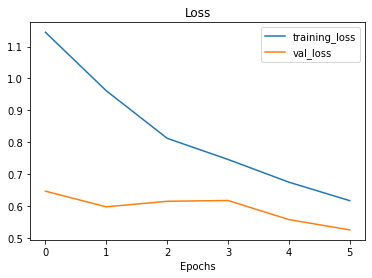

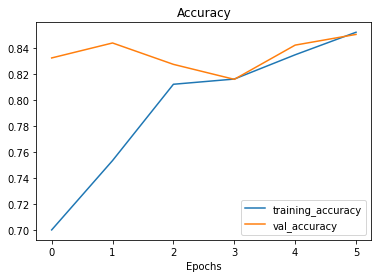

In [150]:
plot_loss_curves(history_3)

In [151]:
# new function to plot the training before and after tuning 
def compare_history(original_history, new_history, initial_epochs=5):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]
  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

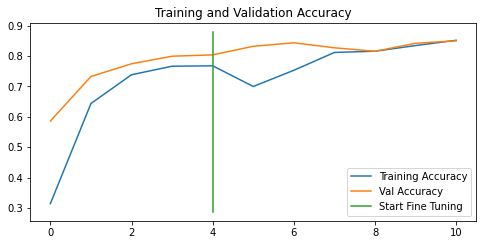

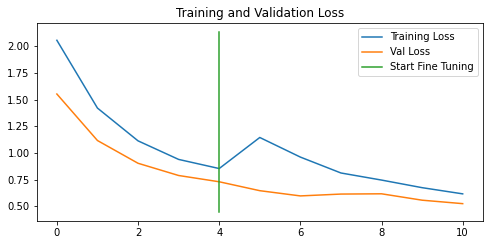

In [152]:
compare_history(history_2,history_3)

## Modal 4

### Data Preprocess

In [153]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')

--2023-03-17 00:38:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  23.9MB/s    in 23s     

2023-03-17 00:39:13 (21.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [154]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.

In [155]:
train_dir_all_data = '/content/10_food_classes_all_data/train'
test_dir_all_data = '/content/10_food_classes_all_data/test'

In [156]:
training_all_data = image_dataset_from_directory(train_dir_all_data,
                                                 label_mode='categorical',
                                                 image_size=(224,224))
testing_all_data = image_dataset_from_directory(test_dir_all_data,
                                                label_mode='categorical',
                                                image_size=(224,224))

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Revert model_2 to feature extraction state 

In [157]:
model_2.load_weights('10_per_ModelCheckpoint_weights/checkpoint.ckpt')

### Fine tune model_2 on the full data

In [164]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f62ab4c52b0> True
<keras.engine.sequential.Sequential object at 0x7f61f8ec6580> True
<keras.engine.functional.Functional object at 0x7f62202e8910> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f62ab4c5ee0> True
<keras.layers.core.dense.Dense object at 0x7f62900bcee0> True


In [165]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_13 False
1 rescaling_12 False
2 normalization_12 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [169]:
model_2.compile(loss= 'categorical_crossentropy',
                optimizer = Adam(0.0001),
                metrics=['accuracy'])

In [171]:
history_4 = model_2.fit(training_all_data,
                        epochs=10,
                        steps_per_epoch=len(training_all_data),
                        validation_data= testing_all_data,
                        validation_steps=int(0.25*len(testing_all_data)),
                        initial_epoch=history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback('/content/transfer_learning',
                                                               'Fine_tuning_all_data')])

Saving TensorBoard log files to: /content/transfer_learning/Fine_tuning_all_data/20230317-012854
Epoch 5/10
235/235 [==============================] - 42s 177ms/step - loss: 0.7116 - accuracy: 0.7792 - val_loss: 0.3918 - val_accuracy: 0.8766
Epoch 6/10
235/235 [==============================] - 43s 183ms/step - loss: 0.6161 - accuracy: 0.8057 - val_loss: 0.3474 - val_accuracy: 0.8882
Epoch 7/10
235/235 [==============================] - 38s 159ms/step - loss: 0.5740 - accuracy: 0.8180 - val_loss: 0.3074 - val_accuracy: 0.9095
Epoch 8/10
235/235 [==============================] - 37s 156ms/step - loss: 0.5252 - accuracy: 0.8309 - val_loss: 0.2919 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 36s 151ms/step - loss: 0.4942 - accuracy: 0.8436 - val_loss: 0.2960 - val_accuracy: 0.9145
Epoch 10/10
235/235 [==============================] - 35s 147ms/step - loss: 0.4702 - accuracy: 0.8499 - val_loss: 0.2927 - val_accuracy: 0.9128


In [172]:
model_2_evaluate_full_data = model_2.evaluate(testing_all_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.3051 - accuracy: 0.9000


In [173]:
print(f'Model 2 {model_2_evaluate}')
print(f'Model 3 {model_2_evaluate_fine_tuned}')
print(f'Model 4 {model_2_evaluate_full_data}')

Model 2 [0.7296015620231628, 0.8040000200271606]
Model 3 [0.5587785840034485, 0.8331999778747559]
Model 4 [0.3050893545150757, 0.8999999761581421]


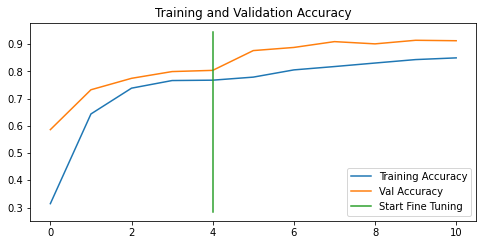

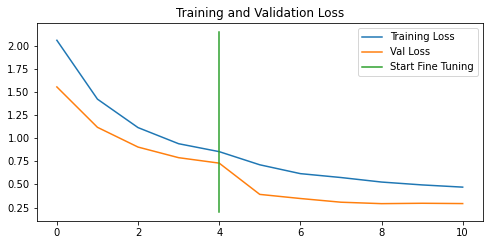

In [174]:
compare_history(history_2, history_4)

### Tensorboard

In [176]:
# https://tensorboard.dev/experiment/vcySzjmkRkKBLVSdAQMO8g/ 
"""
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading
"""  

'\n!tensorboard dev upload --logdir ./transfer_learning   --name "Transfer Learning Experiments with 10 Food101 Classes"   --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning."   --one_shot # exits the uploader once its finished uploading\n'

In [177]:
# !tensorboard dev list

In [178]:
# !tensorboard dev delete --experiment_id vcySzjmkRkKBLVSdAQMO8g # Change this for the experiment ID you want to delete